# Generate Genetic Distance Error vs Omega Error Plots
### Setup

In [12]:
import os
from collections import defaultdict
from json import dumps

from pandas import DataFrame
from pymongo import MongoClient
from IPython.display import Markdown, display, Image

import lib
from outliers import qcrop_facet_grid

In [13]:
%load_ext rpy2.ipython
%R library(ggplot2)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array(['ggplot2', 'quantreg', 'SparseM', 'tools', 'stats', 'graphics',
       'grDevices', 'utils', 'datasets', 'methods', 'base'], 
      dtype='|S9')

In [14]:
try:
    os.mkdir('omega')
except OSError:
    pass

### Utility

In [15]:
def get_lengths(col):
    return {d['_id']:d['lf']['EN'] for d in col.find()
           if max(d['lf']['params']['length'].values()) < 10.-1e-4}

def get_omegas(col):
    return {d['_id']:{t:p['bin0'] for t, p in d['lf']['params']['omega'].items()} 
                  for d in col.find()}

def recommend_crop(x, nq=4.):
    qs = r.quantile(FloatVector(x), probs=FloatVector((0.25,0.5,0.75)))
    return qs[1] - nq*(qs[1]-qs[0]), qs[1] + nq*(qs[2]-qs[1])

def combine_crops(crop1, crop2):
    return min(crop1[0],crop2[0]), max(crop1[1], crop2[1])

def get_points_for_model(database, model):
    col = database.GNC
    GNC_omegas = get_omegas(col)
    GNC_lengths = get_lengths(col)
    col = getattr(database, model)
    model_omegas = get_omegas(col)
    model_lengths = get_lengths(col)
    points = []
    for _id in GNC_omegas:
        if not _id in GNC_lengths or _id not in model_lengths:
            continue
        for taxon in model_omegas[_id]:
            x = model_lengths[_id][taxon] - GNC_lengths[_id][taxon]
            y = model_omegas[_id][taxon] - GNC_omegas[_id][taxon]
            points.append((x, y, taxa[taxon], model))
    return points

def get_dataframe(database):
    Y98_points = get_points_for_model(database, 'Y98')
    print 'Y98', len(Y98_points)/3, 'points'
    CNFGTR_points = get_points_for_model(database, 'CNFGTR')
    print 'CNFGTR', len(CNFGTR_points)/3, 'points'
    cropped_points = zip(*qcrop_facet_grid(Y98_points+CNFGTR_points))
    df = dict(zip(('x', 'y', 'column', 'row', 'xcrop', 'ycrop'), cropped_points))
    return DataFrame(df)

def print_logs(log,  level='INFO'):
    printmd('##### ' + log.name)
    for d in log.find({'level':level}):
        printmd(dumps(d['message']))
        
def printmd(string):
    ''' thanks http://stackoverflow.com/questions/32026727/format-output-of-code-cell-with-markdown '''
    display(Markdown(string))

In [16]:
%%R

get_ggplot <- function(df)
{   
    ggplot(df, aes(xcrop, ycrop))  +
        geom_point(aes(xcrop, ycrop), alpha=0.5, size=0.5) +
        xlab('Branch Length Error') +
        ylab(expression(paste(omega,' Error'))) +
        stat_smooth(method=lm, formula=y~0+x, size=0.75, alpha=0.5, colour="white") + 
        stat_smooth(method=lm, formula=y~0+x, size=0.5, colour="black", se=FALSE) + 
        facet_grid(row ~ column, space="free", scale="free") +
        theme(axis.text.x = element_text(angle=90, vjust = 0.5, hjust=1))
}

### Load the Data

In [17]:
client = MongoClient()

In [18]:
cols = ['GNC', 'Y98', 'CNFGTR']
datasets = ['mammals', 'ants', 'hum_xen_fug']
ds_names = {'mammals' : 'Mammals',
            'ants' : 'Ants',
            'hum_xen_fug' : 'Human/Xenopus/Fugu'}
taxa = {'Human' : 'Human',
       'Xenopus' : 'Xenopus',
       'Fugu' : 'Fugu',
       'Mouse' : 'Mouse', 
       'Opossum' : 'Opossum',
       'Cflo_3_3' : 'C. floridanus',
       'Hsal_3_3' : 'H. saltator',
       'Lhum_1_0' : 'L. humile'}
for dataset in datasets:
    printmd('#### ' + ds_names[dataset])
    for col in ['data'] + cols:
        print_logs(getattr(getattr(client, dataset), col + '.log'))

#### Mammals

##### data.log

{"input_directory": "/short/xe9/bdk248/data/mammals", "log_level": "DEBUG", "output_collection": "mammals.data", "tree_file": "../config/mammals.nwk", "db_host": "r2081", "aln_length": 1500, "log_name": "log", "codon_position": -1}

{"mong": "0.0.10-dev", "cogent": "1.5.3-dev", "masterslave": "0.0.10-dev", "consume": "0.0.5-dev", "monglog": "0.0.1-dev"}

##### GNC.log

{"function": "ml.ml", "start_over": true, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/GNC.json", "input_collection": "mammals.data", "output_collection": "mammals.GNC", "output_collections_file": null, "output_collections": ["mammals.GNC"], "db_host": "r2081", "input_collections_file": null, "kwargs": {"model": "GNC"}, "log_name": "log", "input_collections": ["mammals.data"]}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.11-dev"}

##### Y98.log

{"function": "ml.ml", "start_over": true, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/Y98.json", "input_collection": "mammals.data", "output_collection": "mammals.Y98", "output_collections_file": null, "output_collections": ["mammals.Y98"], "db_host": "r2081", "input_collections_file": null, "kwargs": {"model": "Y98"}, "log_name": "log", "input_collections": ["mammals.data"]}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.11-dev"}

##### CNFGTR.log

{"function": "ml.ml", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/CNFGTR.json", "input_collection": "mammals.data", "output_collection": "mammals.CNFGTR", "output_collections_file": null, "output_collections": ["mammals.CNFGTR"], "db_host": "r2081", "input_collections_file": null, "kwargs": {"model": "CNFGTR"}, "log_name": "log", "input_collections": ["mammals.data"]}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.11-dev"}

#### Ants

##### data.log

{"input_directory": "/short/xe9/bdk248/../data/ants", "log_level": "DEBUG", "output_collection": "ants.data", "tree_file": "../config/ants.nwk", "db_host": "r2081", "aln_length": 1500, "log_name": "log", "codon_position": -1}

{"mong": "0.0.10-dev", "cogent": "1.5.3-dev", "masterslave": "0.0.10-dev", "consume": "0.0.5-dev", "monglog": "0.0.1-dev"}

##### GNC.log

{"function": "ml.ml", "start_over": true, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/GNC.json", "input_collection": "ants.data", "output_collection": "ants.GNC", "output_collections_file": null, "output_collections": ["ants.GNC"], "db_host": "r2081", "input_collections_file": null, "kwargs": {"model": "GNC"}, "log_name": "log", "input_collections": ["ants.data"]}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.11-dev"}

##### Y98.log

{"function": "ml.ml", "start_over": false, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/Y98.json", "input_collection": "ants.data", "output_collection": "ants.Y98", "output_collections_file": null, "output_collections": ["ants.Y98"], "db_host": "r2081", "input_collections_file": null, "kwargs": {"model": "Y98"}, "log_name": "log", "input_collections": ["ants.data"]}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.11-dev"}

##### CNFGTR.log

{"function": "ml.ml", "start_over": true, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/CNFGTR.json", "input_collection": "ants.data", "output_collection": "ants.CNFGTR", "output_collections_file": null, "output_collections": ["ants.CNFGTR"], "db_host": "r2081", "input_collections_file": null, "kwargs": {"model": "CNFGTR"}, "log_name": "log", "input_collections": ["ants.data"]}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.11-dev"}

#### Human/Xenopus/Fugu

##### data.log

{"input_directory": "/short/xe9/bdk248/../data/hum_xen_fug", "log_level": "DEBUG", "output_collection": "hum_xen_fug.data", "tree_file": "../config/hum_xen_fug.nwk", "db_host": "r2081", "aln_length": 1500, "log_name": "log", "codon_position": -1}

{"mong": "0.0.10-dev", "cogent": "1.5.3-dev", "masterslave": "0.0.10-dev", "consume": "0.0.5-dev", "monglog": "0.0.1-dev"}

##### GNC.log

{"function": "ml.ml", "start_over": true, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/GNC.json", "input_collection": "hum_xen_fug.data", "output_collection": "hum_xen_fug.GNC", "output_collections_file": null, "output_collections": ["hum_xen_fug.GNC"], "db_host": "r2081", "input_collections_file": null, "kwargs": {"model": "GNC"}, "log_name": "log", "input_collections": ["hum_xen_fug.data"]}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.11-dev"}

##### Y98.log

{"function": "ml.ml", "start_over": true, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/Y98.json", "input_collection": "hum_xen_fug.data", "output_collection": "hum_xen_fug.Y98", "output_collections_file": null, "output_collections": ["hum_xen_fug.Y98"], "db_host": "r2081", "input_collections_file": null, "kwargs": {"model": "Y98"}, "log_name": "log", "input_collections": ["hum_xen_fug.data"]}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.11-dev"}

##### CNFGTR.log

{"function": "ml.ml", "start_over": true, "log_level": "DEBUG", "no_mpi_main_loop": false, "kwargs_file": "../config/CNFGTR.json", "input_collection": "hum_xen_fug.data", "output_collection": "hum_xen_fug.CNFGTR", "output_collections_file": null, "output_collections": ["hum_xen_fug.CNFGTR"], "db_host": "r2081", "input_collections_file": null, "kwargs": {"model": "CNFGTR"}, "log_name": "log", "input_collections": ["hum_xen_fug.data"]}

{"mong": "0.0.10-dev", "monglog": "0.0.1-dev", "map_collection": "0.0.8-dev", "masterslave": "0.0.10-dev", "ml": "0.0.11-dev"}

In [19]:
dfs = {}
for dataset in datasets:
    printmd('#### ' + ds_names[dataset])
    df = get_dataframe(getattr(client, dataset))
    dfs[dataset] = df

#### Mammals

Y98 4140 points
CNFGTR 4149 points


#### Ants

Y98 2019 points
CNFGTR 2019 points


#### Human/Xenopus/Fugu

Y98 1074 points
CNFGTR 1622 points


### Generate the Plots

#### Mammals

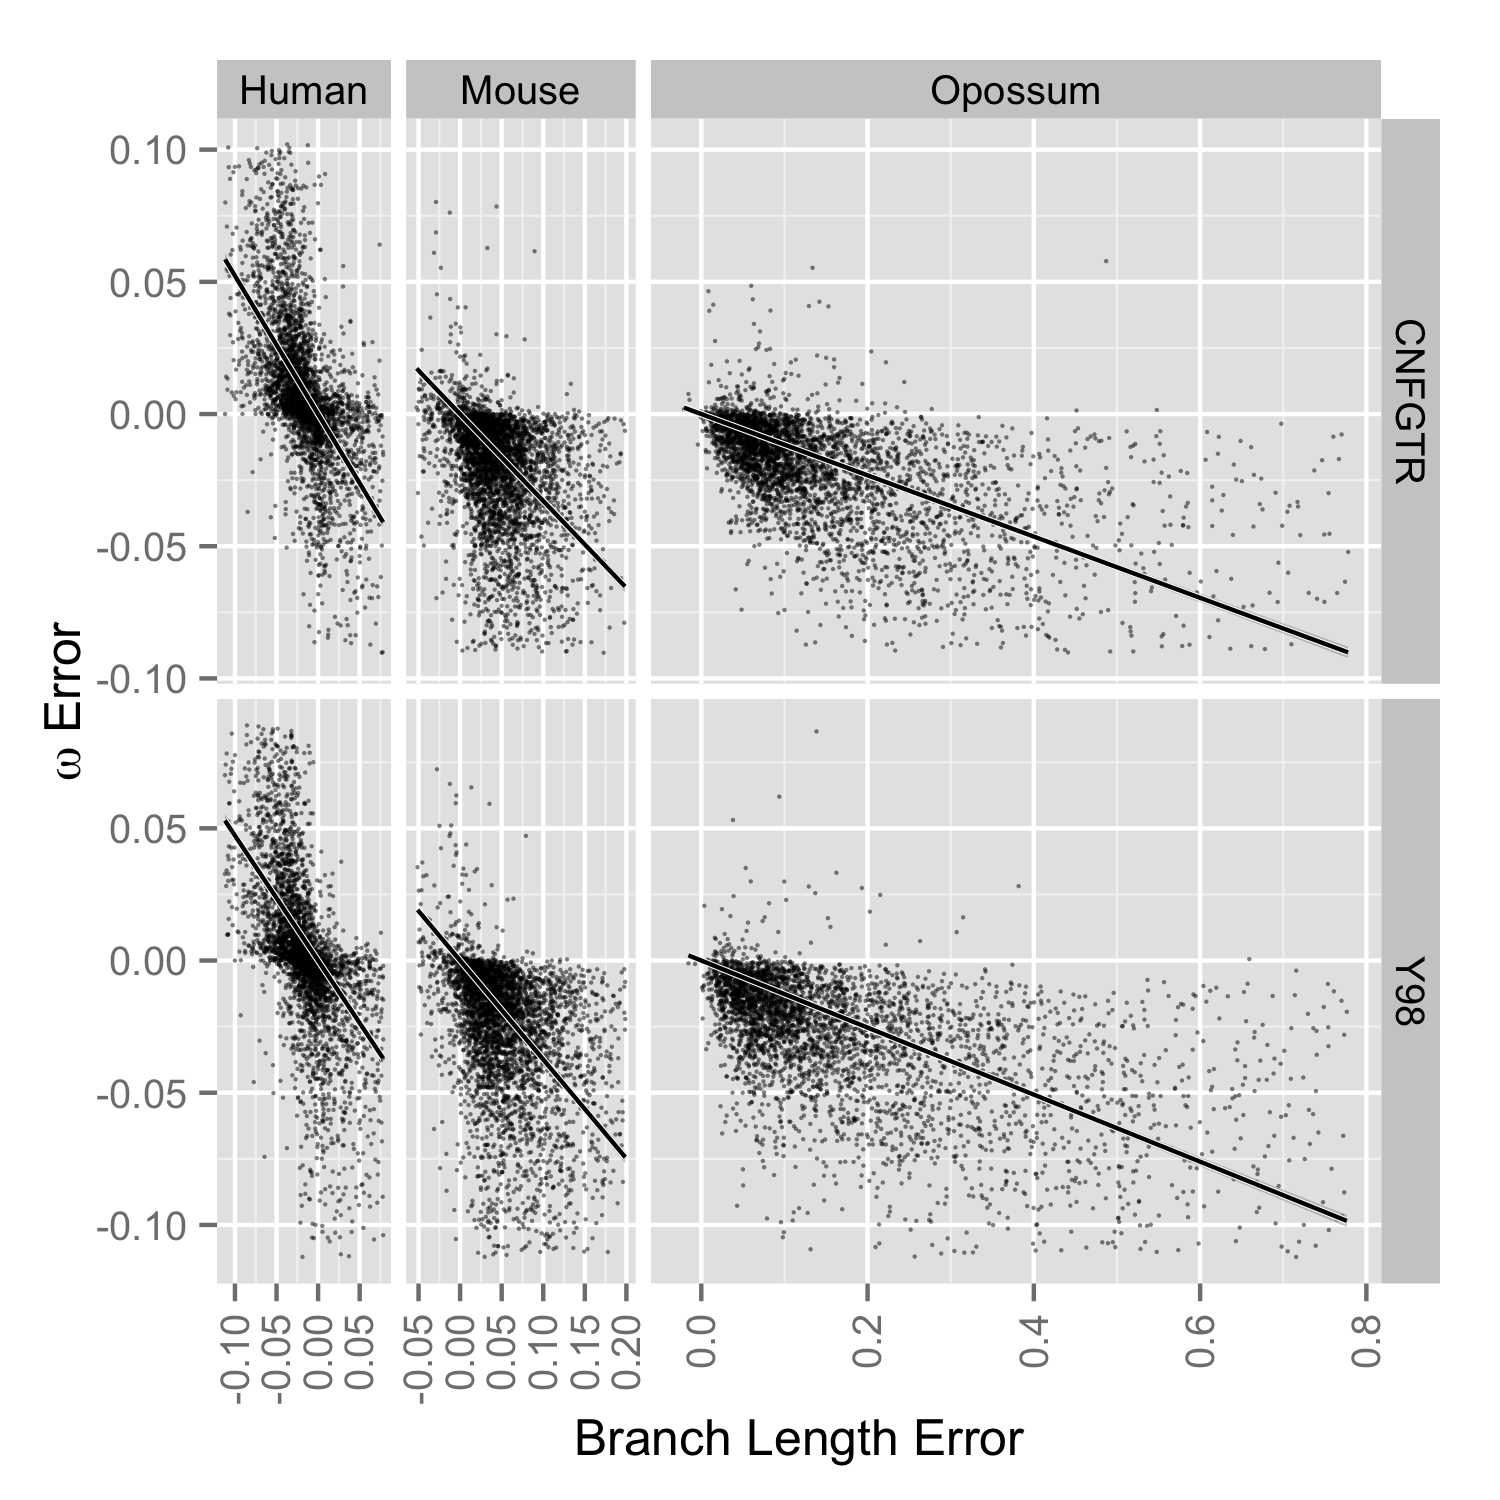

#### Human/Xenopus/Fugu

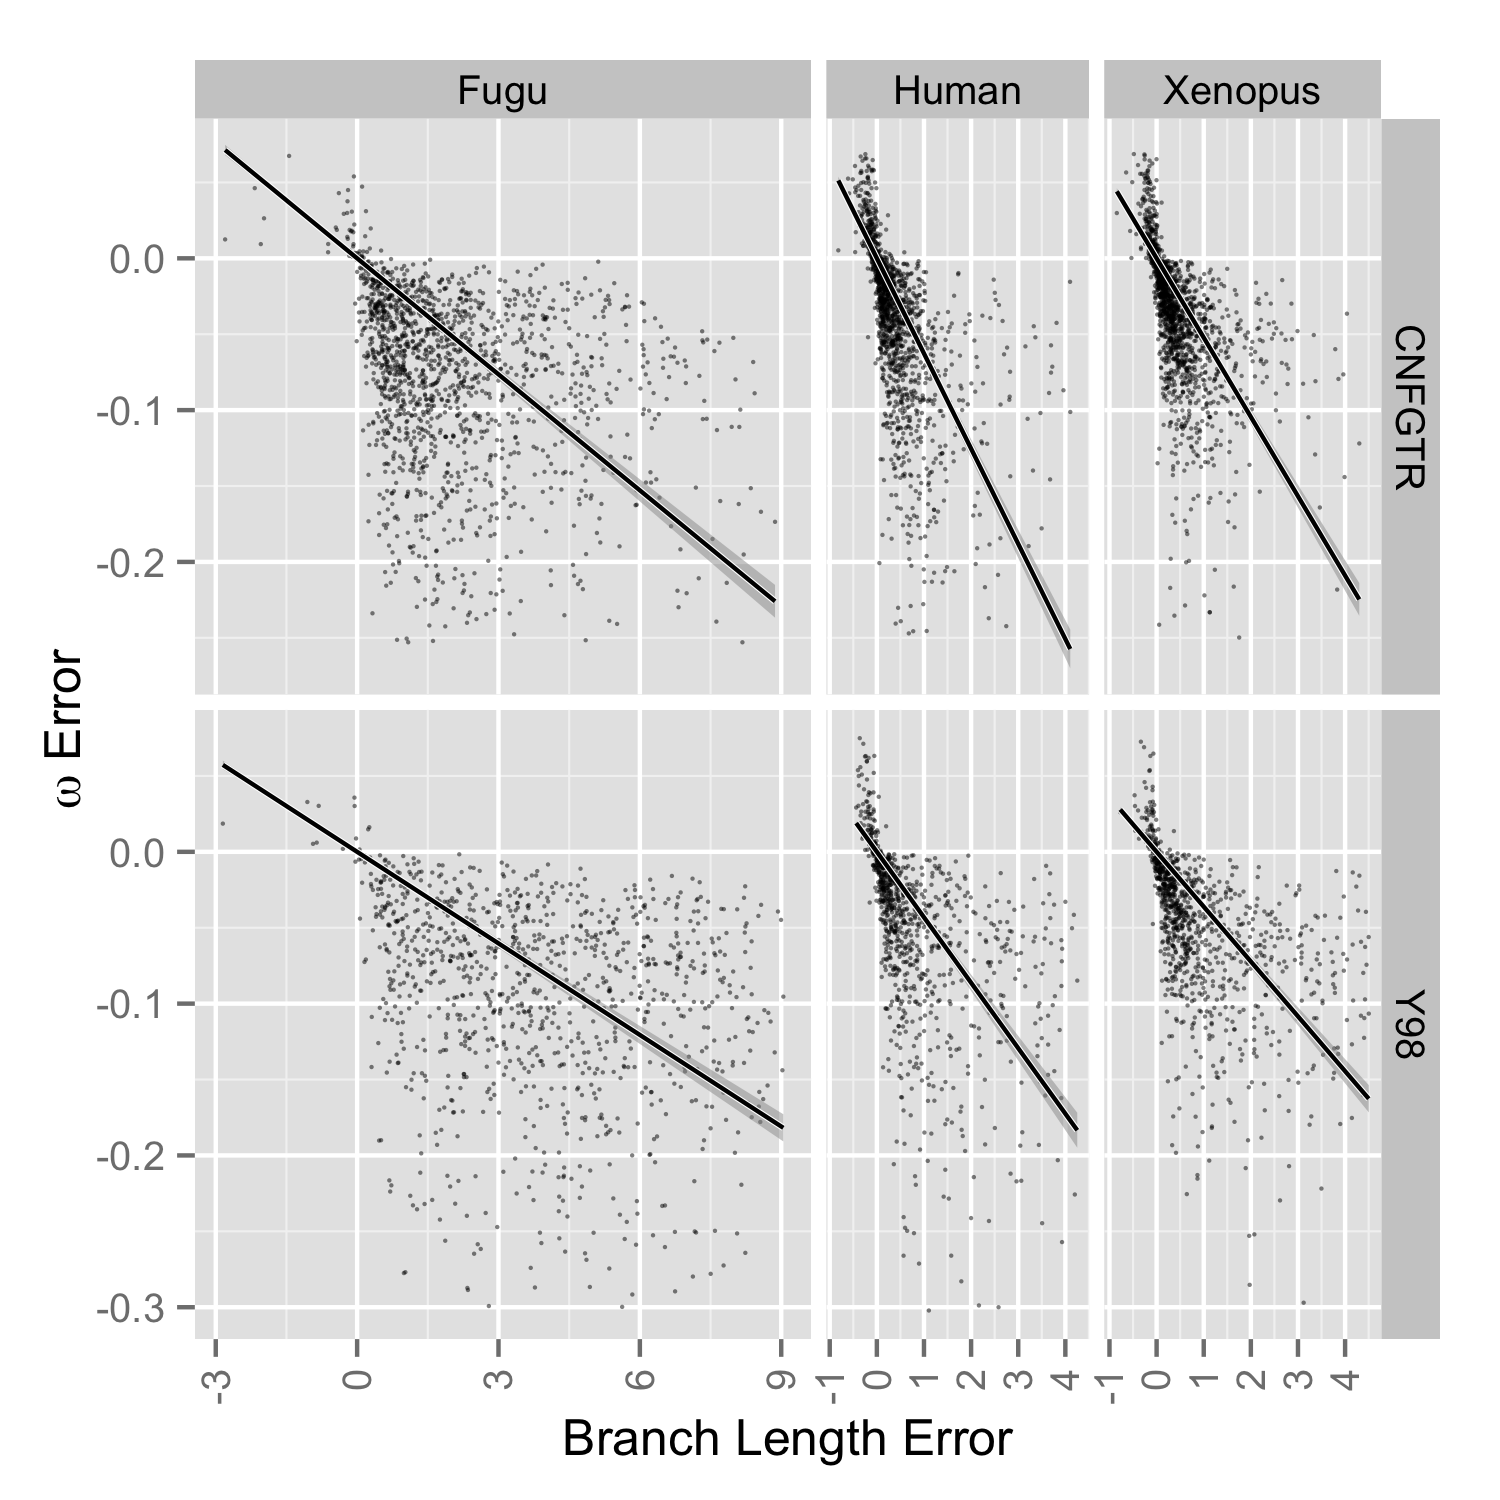

#### Ants

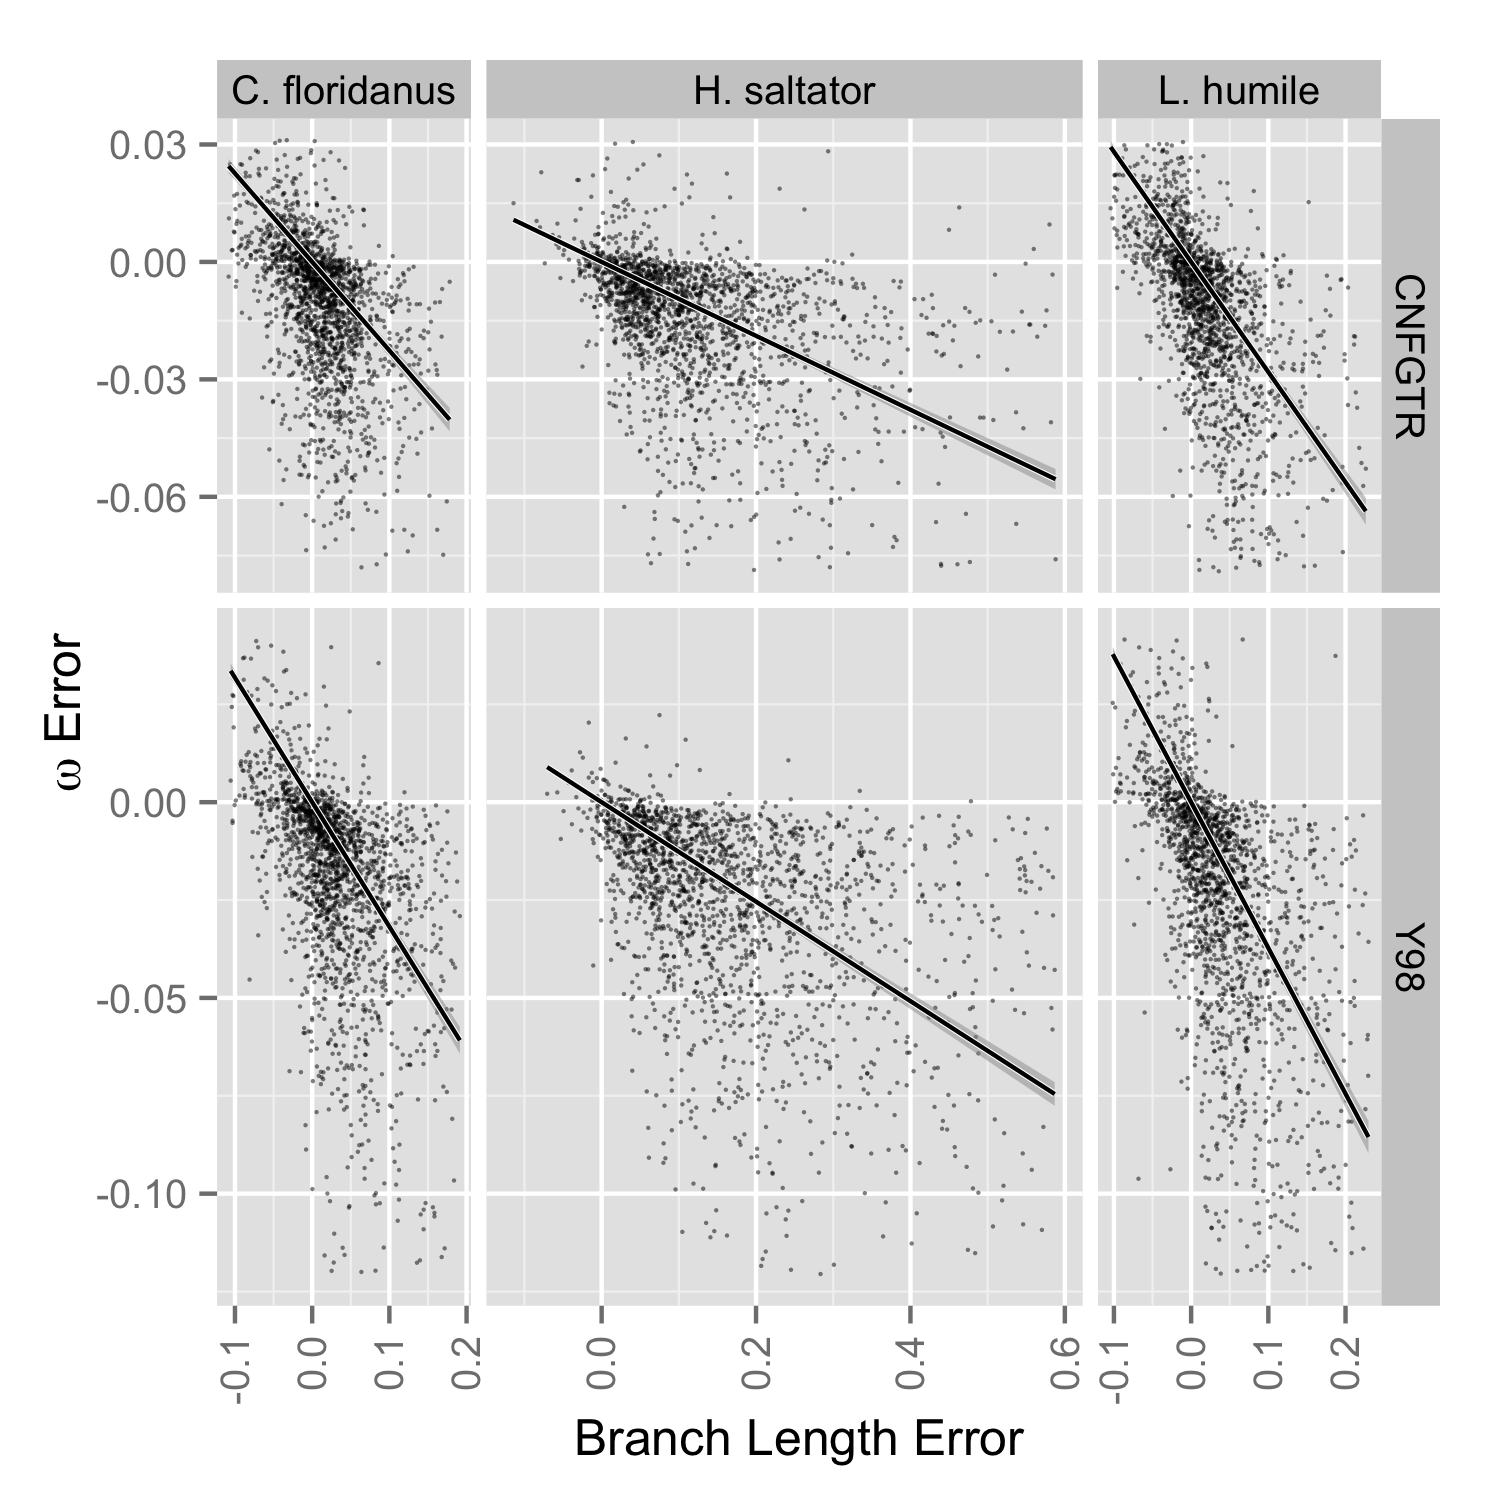

In [20]:
for name, df in dfs.items():
    printmd('#### ' + ds_names[name])
    name = os.path.join('omega', name + '.png')
    %R -i df,name ggsave(name, get_ggplot(df), width=5, height=5)
    display(Image(name))